In [5]:
### Function Imports
from OptionsFunctions import set_price_and_strike, daily_returns, compute_sigma, black_scholes, hedge_pos_and_rets, calculate_hedged_unhedged, plot_hedged_returns, performance_metrics
import pandas as pd
import numpy as np


In [6]:
### Variable Declaration
all_forex_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'NZDUSD=X',
        'USDCAD=X', 'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURNZD=X',
        'EURCAD=X', 'GBPAUD=X', 'GBPJPY=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCHF=X',
        'AUDNZD=X', 'NZDJPY=X', 'NZDCHF=X', 'CADJPY=X', 'CADCHF=X', 'CHFJPY=X'
    ]
start_date = '2023-07-01'
end_date = '2024-07-01'
long_pos = 1000
option_type = 'call'
r = 0.02
r_f = 0.01
T = 1


In [7]:
### Compute Hedged Returns for All Pairs and Filter to find most Profitable
hedge_ratios_df = pd.DataFrame(columns = ['Pair', 'Option Type', 'Option Premium', 'Delta', 'Long Position', 'Short Position', 'Hedged Returns', 'Unhedged Returns'])

for pair in all_forex_pairs:
    try:
        # Assuming the functions 'set_price_and_strike', 'daily_returns', 'black_scholes', 'hedge_position', and 'calculate_hedged_unhedged' are defined elsewhere
        forex_data, S_0, K = set_price_and_strike(pair, start_date, end_date, option_type = 'call')
        daily_rets = daily_returns(forex_data)
        sigma = compute_sigma(daily_rets)
        option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type = 'call')
        hedge_pos, hedged_rets = hedge_pos_and_rets(daily_rets, delta, long_pos)
        hedge_pos, hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(pair, long_pos, daily_rets, delta)

        new_row = pd.DataFrame({
            'Pair': [pair],
            'Option Type': [option_type],
            'Option Premium': [option_price],
            'Delta': [delta],
            'Long Position': [long_pos],
            'Short Position': [hedge_pos],
            'Hedged Returns': [hedged_cumulative_rets.iloc[-1] if not hedged_cumulative_rets.empty else None],
            'Unhedged Returns': [unhedged_cumulative_rets.iloc[-1] if not unhedged_cumulative_rets.empty else None]
        })

        hedge_ratios_df = pd.concat([hedge_ratios_df, new_row], ignore_index=True)

    except Exception as e:
        print(f"Error computing hedge ratio for {pair}: {e}")

#print(hedge_ratios_df.tail())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [8]:
### Filter for Most Profitable Hedged Pairing
# Sort the DataFrame by the 'Hedged Returns' column in descending order
most_profit_hedged = hedge_ratios_df.sort_values(by = 'Hedged Returns', ascending = False).head(1)
#print(most_profit_hedged)

### Display Results
high_pair = most_profit_hedged.iloc[0]['Pair']
option_type = most_profit_hedged.iloc[0]['Option Type']
high_option_premium = most_profit_hedged.iloc[0]['Option Premium']
high_long_position = most_profit_hedged.iloc[0]['Long Position']
high_short_position = most_profit_hedged.iloc[0]['Short Position']
high_hedged_returns = most_profit_hedged.iloc[0]['Hedged Returns']
high_unhedged_returns = most_profit_hedged.iloc[0]['Unhedged Returns']

print(f"Most Profitable Pairing: {high_pair}")
print(f"Option Type: {option_type}")
print(f"Option Premium: {high_option_premium:.6f}")
print(f"Long Position: {high_long_position}")
print(f"Short Position: {high_short_position:.6f}")
print("\nReturns:")
print(f"Hedged Returns: {high_hedged_returns:.6f}")
print(f"Unhedged Returns: {high_unhedged_returns:.6f}")


Most Profitable Pairing: USDJPY=X
Option Type: call
Option Premium: 4.627643
Long Position: 1000
Short Position: 465.770331

Returns:
Hedged Returns: 1553.324627
Unhedged Returns: 1112.806286


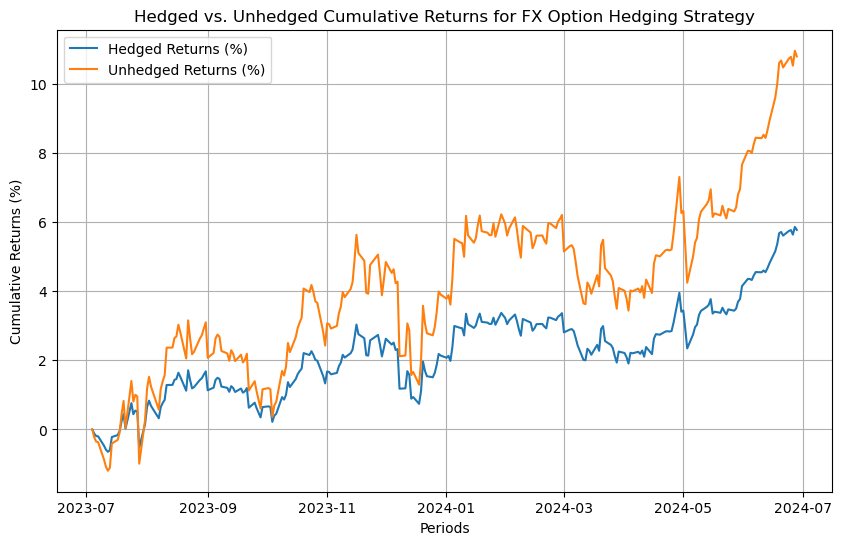

In [9]:
### Plot Hedged vs. Unhedged Returns
plot_hedged_returns(hedged_cumulative_rets, unhedged_cumulative_rets)


In [11]:
### Call Performance Metrics Function
performance_metrics(long_pos, hedge_pos, hedged_cumulative_rets, unhedged_cumulative_rets, daily_rets)



Performance Metrics for Hedged and Unhedged Positions
Metric                                  Hedged        Unhedged
Total Returns (%)                       5.8034         10.8486
Annualized Returns (%)                  5.6422         10.5405
Mean Return                             0.0557          0.1031
Standard Deviation                      0.0414          0.0767
Sharpe Ratio                            1.3446          1.3446

The Sharpe ratio measures the risk-adjusted return of an investment.
In this instance, the hedged strategy has a Sharpe ratio of 1.3446,
which means for every unit of risk, the hedged portfolio is generating 1.3446 units of return above the risk-free rate.
The unhedged strategy has a Sharpe ratio of 1.3446,
indicating that for every unit of risk, the unhedged portfolio is generating 1.3446 units of return above the risk-free rate.
A higher Sharpe ratio typically indicates a more favorable risk-adjusted return.
